![QUORA](https://i.imgur.com/wJqNOG4.jpg)

<h2>Business Problem</h2>
 <h3>About Quora</h3> 
  <p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
</p>
<h3>Problem Statement</h3>
* We have to identify if two questions are similar semantically.
* We do this because when a user posts a new question we have to verify if similar question has already been asked.
* If a similar question has already been asked we can suggest same answers inabling instant solution for the questoin


<h3>Real world objectives</h3>
* Misclassification is of utmost important.Because imagine there are two questions Q1-how to get rid of rats? and Q2- how to get rid of life ? one of the answer for Q1 is **Use ammonia** now we misclassify Q1 and Q2 as similar ,you know what happens next.
<br>
Even if the user is not satisfied with answers he/she might not visit again so classifying properly is crucial.

* Since this a text similarity problem we can use probabilties and a threshold to classify them as same or not.

* Solution interpretability is actually not important when deployed but its good to know.
* Not a real time problem so no strict low latency constraint is demanded.

<h2>Machine learning Problem</h2>

<h3>Source:  [kaggle](https://www.kaggle.com/c/quora-question-pairs/)</h3>
<h3>Data overiew</h3>

* Train.csv(only) contains below metioned fields
* id - the id of a training set question pair
* qid1, qid2 - unique ids of each question (only available in train.csv)
* question1, question2 - the full text of each question
* is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

* Size of Train.csv is 60MB
* No of rows in Train.csv is  404k

<h3>Example instance</h3>
![alt text](https://i.imgur.com/ZdUy5Z4.png)

<h2>Mapping the real world problem to Machine learning problem</h2>

<h3>Type of ML problem </h3>
Since we have to predict whether Q1 and Q2 are similar or not. It is a binary classification problem.


<h3>Performance metric</h3>
* log-loss


<h2>Exploratory Data Analysis</h2>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import os
os.chdir('/content/gdrive/My Drive/Quora questions pair')
os.listdir()

['train.csv', 'df_fe_without_preprocessing_train.csv']

In [4]:
df = pd.read_csv("train.csv")
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
#missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


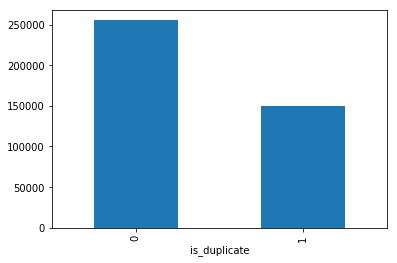

In [7]:
# df.groupby("is_duplicate").count().plot.bar()
df.groupby("is_duplicate")['id'].count().plot.bar()

In [8]:
non_duplicate = df['is_duplicate'].value_counts()[0]
duplicate = df.shape[0]-non_duplicate
print("Duplicate : {:0.2f}%".format((duplicate/df.shape[0])*100))
print("Non duplicate : {:0.2f}%".format((non_duplicate/df.shape[0])*100))

Duplicate : 36.92%
Non duplicate : 63.08%


In [9]:
l = df['qid1'].tolist() + df['qid2'].tolist()
unique_quest = pd.Series(l).value_counts()
print('Most repeated question count :',unique_quest.iloc[0])
print('Total number of unique questions {} : '.format(len(unique_quest)))
print('Number of questions which appeared more than once : ',len(unique_quest[unique_quest > 1]))


Most repeated question count : 157
Total number of unique questions 537933 : 
Number of questions which appeared more than once :  111780


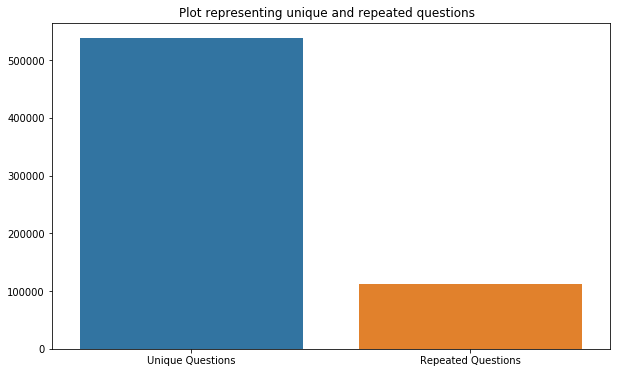

In [10]:

x = ["Unique Questions" , "Repeated Questions"]
y =  [len(unique_quest),len(unique_quest[unique_quest > 1])]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [11]:
#duplicates presence 
df[df.duplicated(['qid1','qid2'])].shape[0]

0

Text(0, 0.5, 'Number of questions')

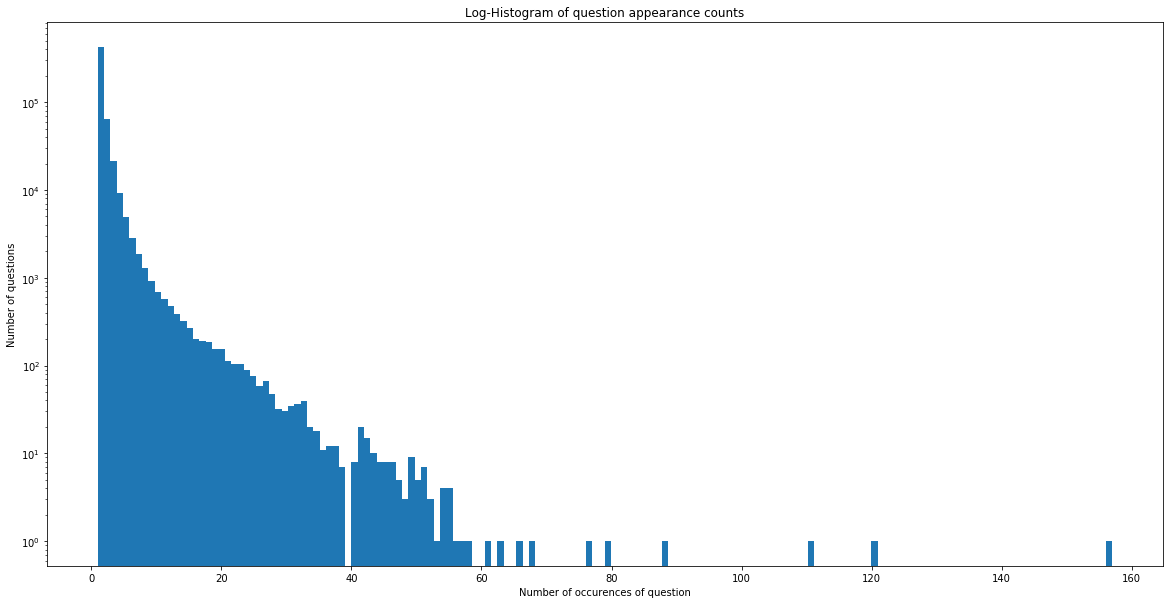

In [12]:
plt.figure(figsize=(20, 10))

plt.hist(unique_quest, bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')



In [13]:
df[df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [0]:
df.dropna(inplace=True)

<h2>Trying out new features</h2>

* freq_qid1 = Frequency of qid1's<br>
* freq_qid2 = Frequency of qid2's <br>
* q1len= Length of q1<br>
* q2len = Length of q2<br>
* q1_n_words = Number of words in Question 1<br>
* q2_n_words = Number of words in Question 2<br>
* word_Common = (Number of common unique words in Question 1 and Question 2)<br>
* word_Total=(Total num of words in Question 1 + Total num of words in Question 2)<br>
* word_share = (word_common)/(word_Total)<br>
* freq_q1+freq_q2= sum total of frequency of qid1 and qid2 <br>
* freq_q1-freq_q2= absolute difference of frequency of qid1 and qid2 <br>

In [15]:
#all are pretty self explanatory .check above points
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [16]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

print('Average number of words in q1 :',df['q1len'].sum()//df.shape[0])
print('Average number of words in q2 :',df['q2len'].sum()//df.shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22
Average number of words in q1 : 59
Average number of words in q2 : 60


word_share feature exploration

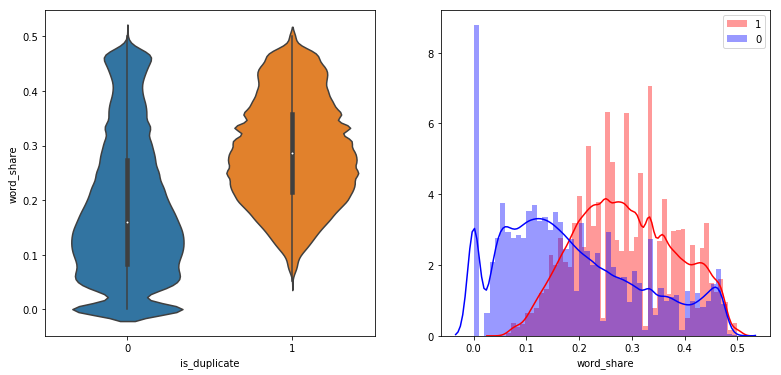

In [17]:
plt.figure(figsize=(13, 6))
#this creates 1 row 2 columns and select 1st plot
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[:])
#selects 2nd plot
plt.subplot(1,2,2)
#this shows that word_share has some importance which helps distinguish classes as seen below in the plot
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][:] , label = "0" , color = 'blue' )
plt.legend()

plt.show()

<h3>Observations</h3>

* as word_share increases we can see that duplicate value increases the red histogram
* in violin plot the center part is sort of like a box plot we can see 25,50,75 percentile.We can see thatmean for duplicate class has greater word_share value that not duplicate

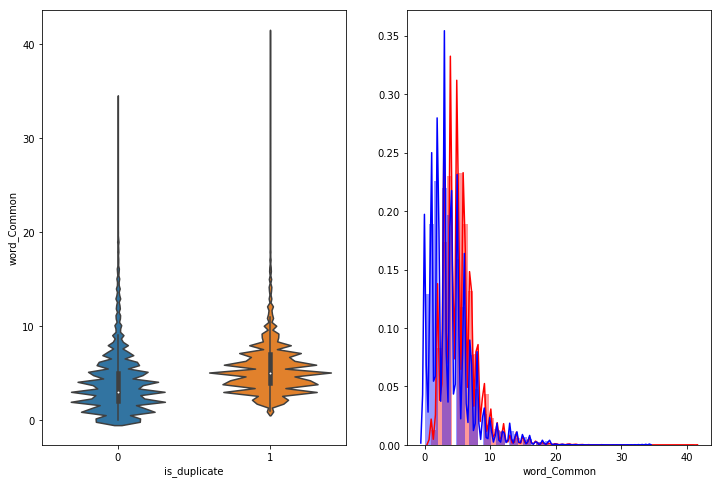

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

As we can see they overlapping so might not be the best feature as it can explain properly.

<h2>Preprocessing</h2>

In [27]:
!pip install fuzzywuzzy
!pip install Distance

In [28]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
